## Text Classification

In [1]:
import os
import spacy
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy import data

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from utils import *
from config import RCNNConfig
from rcnn import RCNN
from cnn import AttentionCNN
from training import train_model, evaluate

import warnings
warnings.filterwarnings('ignore')

### Read data from CSV file

In [2]:
data_df = pd.read_csv("../data/yelp_ratings.csv")

In [3]:
data_df

,text,stars,sentiment
0,Total bill for this horrible service? Over $8G...,1.0,0
1,I *adore* Travis at the Hard Rock's new Kelly ...,5.0,1
2,I have to say that this office really has it t...,5.0,1
3,Went in for a lunch. Steak sandwich was delici...,5.0,1
4,Today was my second out of three sessions I ha...,1.0,0
...,...,...,...
44525,"Petit café sympa, peu de place assise. Bonne b...",4.0,1
44526,Absolutely delicious! The food was full of ama...,5.0,1
44527,I love this place! They always have the cutes...,4.0,1
44528,i would understand a 2 hour wait for food if i...,2.0,0


In [4]:
data_df.drop(columns={'stars'}, inplace=True)
data_df.rename(columns={'sentiment': 'label'}, inplace=True)
data_df

,text,label
0,Total bill for this horrible service? Over $8G...,0
1,I *adore* Travis at the Hard Rock's new Kelly ...,1
2,I have to say that this office really has it t...,1
3,Went in for a lunch. Steak sandwich was delici...,1
4,Today was my second out of three sessions I ha...,0
...,...,...
44525,"Petit café sympa, peu de place assise. Bonne b...",1
44526,Absolutely delicious! The food was full of ama...,1
44527,I love this place! They always have the cutes...,1
44528,i would understand a 2 hour wait for food if i...,0


In [5]:
print(len(data_df[data_df['label'] == 0]))
print(len(data_df[data_df['label'] == 1]))

11199
33331


### Split data to train and validation

In [6]:
train_df, valid_df = train_test_split(data_df, test_size=0.1, random_state=1)

In [7]:
print(len(train_df), len(valid_df))

40077 4453


In [8]:
train_df.to_csv('../data/yelp-train.csv', index=False)
valid_df.to_csv('../data/yelp-valid.csv', index=False)

In [9]:
train_df = pd.read_csv('../data/yelp-train.csv')
valid_df = pd.read_csv('../data/yelp-valid.csv')

valid_df

,text,label
0,"I ordered nachos, soft serve ice cream, and a ...",0
1,The restaurant with the food truck theme was v...,1
2,Theft is a problem at the Venetian. Risk Manag...,0
3,This the slowest fast food place ever. They ar...,0
4,Christina... f-en amazing. The best service e...,1
...,...,...
4448,"Having read the reviews, I was leery renting f...",1
4449,We started at Dynamics two years ago & we have...,1
4450,Outrageous. This is the best show i have ever ...,1
4451,"They just added few items to the menu, tonight...",1


### Using torchtext
1. Define fields
2. Define datasets (train, validation, test)
3. Build vocabulary for each field
3. Define iterators for each dataset

In [10]:
spacy_en = spacy.blank('en')
def tokenize(text, min_length=5):
    text = text.lower().strip();
    text = ' '.join(text.split())
    tokens = [t.text for t in spacy_en.tokenizer(text)]
    
    if len(tokens) < min_length:
        tokens += ['<pad>' for i in range(min_length - len(tokens))]
    return tokens

In [11]:
TEXT = data.Field(tokenize=tokenize)

LABEL = data.LabelField()

In [12]:
train_data, valid_data = data.TabularDataset.splits(
    path="../data/",
    train='yelp-train.csv',
    validation='yelp-valid.csv',
    format='CSV',
    skip_header=True,
    fields=[('text', TEXT), ('label', LABEL)]
)

print(vars(train_data[0]))
print(vars(valid_data[0]))

{'text': ['cute', 'coffee', 'place', 'with', 'lots', 'of', 'selection', 'from', 'coffee', 'to', 'non', 'coffee', 'drink', 'and', 'waffles', 'even', 'gelato', 'which', 'all', 'is', 'amazing', '!', '!', '!', '!', 'i', 'had', 'the', 'sweet', 'box', 'latte', ',', 'it', 'is', "n't", 'sweet', 'but', 'the', 'flavor', 'of', 'coffee', 'is', 'good', 'and', 'will', 'sure', 'wakes', 'you', 'up', '!', '!', '!'], 'label': '1'}
{'text': ['i', 'ordered', 'nachos', ',', 'soft', 'serve', 'ice', 'cream', ',', 'and', 'a', 'salad', '.', 'probably', 'the', 'easiest', 'things', 'to', 'prepare', '.', 'it', 'took', 'a', 'half', 'hour', 'and', ',', 'if', 'i', 'had', "n't", 'looked', 'in', 'the', 'bag', '-', 'i', 'ordered', 'everything', 'to', 'go', '-', 'i', 'would', "n't", 'have', 'realized', 'that', 'they', 'forgot', 'an', 'item', '.', 'terrible', 'service', 'and', 'they', 'did', "n't", 'care', 'on', 'bit', '.', 'i', 'will', 'never', 'go', 'back', '!'], 'label': '0'}


In [13]:
# Build vocabulary for texts
vocab_size = 20_000

TEXT.build_vocab(train_data,
                 max_size=vocab_size)

# Build vocabulary for labels
LABEL.build_vocab(train_data)
print(LABEL.vocab.stoi)

defaultdict(None, {'1': 0, '0': 1})


In [14]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator = data.BucketIterator(
    train_data, 
    batch_size, 
    sort_key=lambda x: len(x.text), 
    device=device)

valid_iterator = data.BucketIterator(
    valid_data, 
    batch_size, 
    sort_key=lambda x: len(x.text), 
    device=device,
    train=False,
    shuffle=False)

## Build Model

In [ ]:
# INPUT_DIM = len(TEXT.vocab)
# OUTPUT_DIM = len(LABEL.vocab)
# DROPOUT = 0.5


# model = AttentionCNN(INPUT_DIM, 
#                      embedding_dim=100, 
#                      n_filters=150, 
#                      filter_sizes=[2,3,4], 
#                      output_dim=OUTPUT_DIM, 
#                      dropout=DROPOUT)

# model = model.to(device)

In [15]:
config = RCNNConfig()

model = RCNN(config, vocab_size=len(TEXT.vocab))
model = model.to(device)


optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
criterion = nn.CrossEntropyLoss().to(device)

## Train the model

In [16]:
model_dir = 'models'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
fname = f'{model_dir}/rcnn-yelp.pt'  # save the trained model

In [17]:
# train the model
train_model(model, device, 
            train_iterator, valid_iterator, 
            optimizer, criterion, scheduler, 
            n_epochs=5, 
            fname=fname)

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Time
0,1,0.356,0.179,84.29,92.70,2m 28s
1,2,0.169,0.137,93.69,94.82,2m 31s
2,3,0.125,0.137,95.63,94.66,2m 30s
3,4,0.110,0.129,96.22,95.11,2m 31s
4,5,0.099,0.136,96.55,95.06,2m 34s


In [18]:
loss, acc = evaluate(model, valid_iterator, criterion)
print(f'Validation loss = {loss:.4f} | validation acc = {acc*100:.2f}%')

Validation: | Loss=0.2544 | Acc=0.9189 |: 100%|██████████| 70/70 [00:01<00:00, 53.10it/s] 

Validation loss = 0.1288 | validation acc = 95.11%


### Testing model on user inputs

In [19]:
nlp = spacy.load("en_core_web_sm")


def predict(model, sentence, device=device):
    model.eval()
    
    # tokenize
    tokens = [t.text for t in nlp(sentence)]
    
    # numericalize
    indexed = [TEXT.vocab.stoi[t] for t in tokens]
    
    # convert to torch tensor and add batch dimension
    indexed = torch.LongTensor(indexed).unsqueeze(1).to(device)
    
    # predict the label
    prediction = model(indexed)
    
    return LABEL.vocab.itos[prediction.argmax(1).item()]
    

In [20]:
docs = ["The food was really awesome!",
        "The food was bad and the place was very very dirty and dark!"]


for doc in docs:
    label = predict(model, doc)
    display_classification_result(doc, label, LABEL.vocab.stoi[label])

1       The food was really awesome!
0       The food was bad and the place was very very dirty and dark!


### Confusion matrix

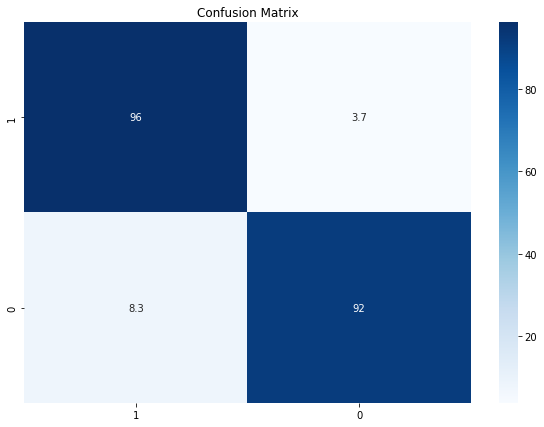

In [21]:
cm, y_true, y_pred = compute_confusion_matrix(model, valid_iterator)
plot_confusion_matrix(cm, LABEL.vocab.stoi)

In [22]:
print(classification_report(y_true, y_pred, target_names=LABEL.vocab.stoi.keys()))

              precision    recall  f1-score   support

           1       0.97      0.96      0.97      3327
           0       0.89      0.92      0.90      1126

    accuracy                           0.95      4453
   macro avg       0.93      0.94      0.94      4453
weighted avg       0.95      0.95      0.95      4453

